# Разбиение данных на обучающую и тестовую выборки

In [1]:
# импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold

In [2]:
# настройка отображения графиков
plt.style.use("fivethirtyeight")

Будем работать с данными, разбитыми на фрагменты по 1000 символов:

In [3]:
# загрузка данных
data = pd.read_csv("../data/splitted_df_1000.csv")

In [4]:
# вывод на экран 5 первых объектов датасета
data.head()

,target,text,book
0,author_id_06,"Узкими горными тропинками , от одного дачного ...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1,author_id_06,эти ... Носил я орган к мастеру — и чинить не ...,raw_data/aleksandr_kuprin_belyj_pudel'.txt
2,author_id_06,"— спросил шарманщик.— Жара , дедушка Лодыжкин ...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
3,author_id_06,", когда весь Крым наполняется нарядной , богат...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
4,author_id_06,раз видел.— Эфиопы ? Знаю . Это которые с рога...,raw_data/aleksandr_kuprin_belyj_pudel'.txt


In [5]:
# вывод на экран количества объектов обучающей выборки
len(data)

3124

Разобьем данные на обучающую и тестовую выборки таким, образом, чтобы:
- тестовая часть составляла ~20% всех данных
- фрагменты из одной книги (group) попадали либо в обучающую, либо в тестовую выборки (чтобы исключить любой возможный data leakage: например, модель выучит имена героев)
- распределение значений целевой переменной в трейне и тесте было максимально похожим.

Поскольку `train_test_split` библиотеки `scikit-learn` не поддерживает groups, используем `StratifiedGroupKFold` с 5 сплитами и выберем такой сплит, при котором среднеквадратичная ошибка между процентами значений каждого класса будет минимальной.

Также будем использовать `StratifiedGroupKFold` с 5 сплитами для кросс-валидации на трейне.

Также переведем значения таргета из `str` в `int`.

In [6]:
# приведение таргента к формату int
data["target"] = data["target"].apply(lambda x: x.removeprefix("author_id_0")).astype(int)

In [7]:
y = data["target"]
X = data["text"]
groups = data["book"]

sgkf = StratifiedGroupKFold(n_splits=5)

In [8]:
best_split = None
best_rmse = float("inf")
best_split_train_inds = None
best_split_test_inds = None

In [9]:
for split, (train_inds, test_inds) in enumerate(sgkf.split(X, y, groups)):
    y_train_percentages = (y[train_inds].value_counts(normalize=True) * 100).sort_index()
    y_test_percentages = (y[test_inds].value_counts(normalize=True) * 100).sort_index()
    split_rmse = root_mean_squared_error(y_train_percentages, y_test_percentages)
    if split_rmse < best_rmse:
        best_split = split
        best_rmse = split_rmse
        best_split_train_inds = train_inds
        best_split_test_inds = test_inds

print(f"best_split: {best_split}")
print(f"best_rmse: {np.round(best_rmse, 2)}")

best_split: 4
best_rmse: 3.65


In [10]:
# проверка, что одни и те же книги не попадают в трейн и тест
assert not bool(
    set(data.loc[best_split_train_inds]["book"]).intersection(
        set(data.loc[best_split_test_inds]["book"])
    )
)

In [11]:
# добавление колонки "сплит" в датасет
data["split"] = data.index.isin(best_split_train_inds)
data["split"] = data["split"].map({True: "train", False: "test"})

In [12]:
# вывод на экран соотношения трейна и теста
(data["split"].value_counts(normalize=True) * 100).round().rename("percentage")

split
train    82.0
test     18.0
Name: percentage, dtype: float64

почти 80/20

посмотрим на соотношение исходного датасета, трейна и теста

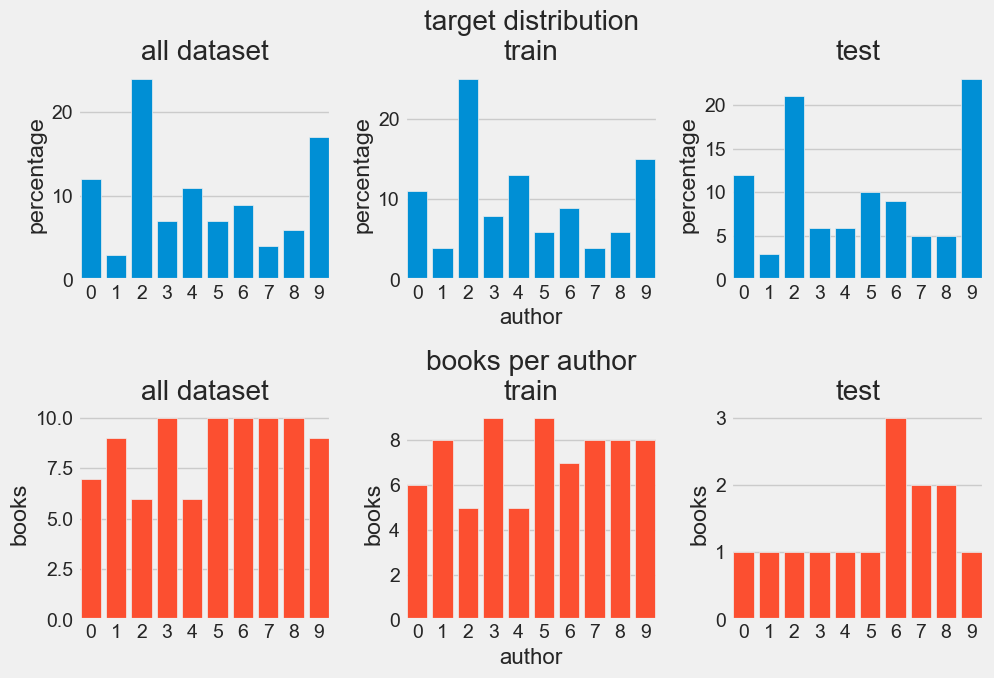

In [13]:
# визализация распределения таргета и количества книг по автору для всего датасета, трейна и теста
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))

for i, target in enumerate([y, y[best_split_train_inds], y[best_split_test_inds]]):
    dts = (target.value_counts(normalize=True) * 100).round().sort_index().tolist()
    sns.barplot(pd.Series(dts, name="percentage"), saturation=1, ax=ax[0][i])

for i, feature in enumerate(
    [data, data.loc[best_split_train_inds], data.loc[best_split_test_inds]]
):
    dts = feature.groupby("target")["book"].nunique().tolist()
    sns.barplot(pd.Series(dts, name="books"), color="#fc4f30", saturation=1, ax=ax[1][i])

ax[0][0].set_title("\nall dataset")
ax[0][1].set_title("target distribution\ntrain")
ax[0][2].set_title("\ntest")

ax[1][0].set_title("\nall dataset")
ax[1][1].set_title("books per author\ntrain")
ax[1][2].set_title("\ntest")

ax[0][1].set_xlabel("author", fontsize=16)
ax[1][1].set_xlabel("author", fontsize=16)

plt.tight_layout()
plt.show()

- по большинству авторов распределения похожи

In [14]:
# сохранение датасетов в отдельные файлы
train = data[data.split == "train"].drop(columns="split")
test = data[data.split == "test"].drop(columns="split")

train.to_csv("../data/split_1000_train.csv")
test.to_csv("../data/split_1000_test.csv")